In [46]:
import geopandas as gpd
import holoviews as hv
import hvplot.pandas
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import panel as pn
import cenpy
import pygris

import dask.dataframe as da
import intake

import requests

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

pd.options.display.float_format = '{:.2f}'.format

In [3]:
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


import altair as alt
from vega_datasets import data as vega_data

In [4]:
NJ_counties = pygris.counties(
    state="NJ", year=2019
)

Using FIPS code '34' for input 'NJ'


In [5]:
NJ_tracts = pygris.tracts(
    state="NJ", year=2019
)

Using FIPS code '34' for input 'NJ'


In [6]:
NJ_block_groups = pygris.block_groups(
    state="NJ", year=2019
)

Using FIPS code '34' for input 'NJ'


In [49]:
data = pd.read_csv("data/claims_NJ.csv")

data['countyCode'] = data['countyCode'].astype(str).str.rstrip('.0')
data['censusTract'] = data['censusTract'].astype(str).str.rstrip('.0')
data['censusBlockGroupFips'] = data['censusBlockGroupFips'].astype(str).str.rstrip('.0')
data['yearOfLoss'] = pd.to_datetime(data['yearOfLoss'], format='%Y').dt.year

sfh = (data['occupancyType'] == 1) | (data['occupancyType'] == 11)
data['sfh'] = np.where(sfh, 1, 0)

data['observation'] = 1

In [50]:
damage = data.groupby("yearOfLoss").sum(numeric_only = True)

damage.head()

,Unnamed: 0,baseFloodElevation,locationOfContents,occupancyType,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,primaryResidenceIndicator,buildingDamageAmount,netBuildingPaymentAmount,buildingPropertyValue,contentsDamageAmount,netContentsPaymentAmount,contentsPropertyValue,floodCharacteristicsIndicator,floodWaterDuration,floodproofedIndicator,buildingReplacementCost,contentsReplacementCost,stateOwnedIndicator,buildingDescriptionCode,rentalPropertyIndicator,latitude,longitude,x,y,sfh,observation
yearOfLoss,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1995,458829933,399.40,588.00,567.00,1302079.60,1038865.71,57864100.00,8647900.00,102,1731917.00,1302079.60,72207971.00,1475497.00,1038865.71,1840000.00,92.00,1531.00,0,790933241.00,0.00,0,14.00,0,13465.50,-25036.50,-2787050431.25,1639031524.80,223,336
1996,4422144898,9285.50,5288.00,5061.00,20680419.00,10444188.46,342046000.00,55205500.00,1530,25251186.00,20677090.97,824886446.00,13641643.00,10431162.38,22826000.00,480.00,8655.00,0,1189303351.00,0.00,1,187.00,0,134439.70,-248225.60,-27632347393.85,16383452737.38,2481,3332
1997,1120667512,3348.00,1432.00,1364.00,4501248.68,2616246.37,91833400.00,18262600.00,342,5152775.00,4501248.28,148105291.00,2983512.00,2616246.37,651850.00,135.00,1733.00,0,153311995.00,0.00,0,69.00,0,33966.20,-63377.50,-7055151027.75,4129569018.82,617,852
1998,4180089436,9084.70,5865.00,4889.00,17210693.27,5578269.14,375515800.00,47467700.00,917,19643977.00,17196684.53,19590340927.00,6762814.00,5578269.14,2306339.00,406.00,8989.00,0,22327423292.00,0.00,1,159.00,0,121492.80,-230217.80,-25627728267.55,14735467868.38,1990,3086
1999,10033596955,60515.80,10400.00,11136.00,110174111.52,38137806.38,921195200.00,136536300.00,5331,123210174.00,110080606.68,187508512069.00,51741380.00,38117621.98,46608760.00,2016.00,44176.00,0,232684737645.00,0.00,1,834.00,2,310422.10,-566476.60,-63059886658.30,37899688025.92,5851,7621


In [65]:
from bokeh.models.formatters import NumeralTickFormatter
formatter = NumeralTickFormatter(format="0,0")
damage.hvplot.line(x='yearOfLoss', 
                  y=(['buildingDamageAmount', 'contentsDamageAmount']),
                  stacked = True,
                  rot=90
                 ).opts(yformatter=formatter)



:NdOverlay   [Variable]
   :Curve   [yearOfLoss]   (value)

In [42]:
claims_NJ = data[(data['yearOfLoss'] >= 2010) & (data['yearOfLoss'] < 2015)]
claims_NJ = claims_NJ[claims_NJ['sfh'] == 1]

#claims_NJ

In [153]:
agg_functions = {
    'amountPaidOnBuildingClaim': ['sum', 'mean'], 
    'amountPaidOnContentsClaim': ['sum', 'mean'],
    'buildingDamageAmount': ['sum', 'mean'],
    'buildingPropertyValue': ['sum', 'mean'],
    'buildingReplacementCost': ['sum', 'mean'],
    'observation': 'sum',
}

In [154]:
claims_by_county = claims_NJ.groupby(["countyCode", "yearOfLoss"]).agg(agg_functions).reset_index()

claims_by_county.columns = ['countyCode', 
                            'yearOfLoss', 
                            'sum_amountPaidOnBuildingClaim', 
                            'mean_amountPaidOnBuildingClaim', 
                            'sum_amountPaidOnContentsClaim', 
                            'mean_amountPaidOnContentsClaim',
                            'sum_amountbuildingDamageAmount', 
                            'mean_amountbuildingDamageAmount',
                            'sum_amountbuildingPropertyValue', 
                            'mean_amountbuildingPropertyValue',
                            'sum_amountbuildingReplacementCost', 
                            'mean_amountbuildingReplacementCost',
                            'observations']

#claims_by_county.head()

In [140]:
NJ_counties_join = claims_by_county.merge(
    NJ_counties,
    left_on=["countyCode"],
    right_on=["GEOID"]
)

NJ_countyClaims_gdf = gpd.GeoDataFrame(NJ_counties_join, geometry=NJ_counties_join['geometry'])

#NJ_countyClaims_gdf

In [110]:
# NJ_countyClaims_gdf.hvplot(
#     c="observations",
#     groupby = "yearOfLoss",
#     frame_width=600,
#     frame_height=600,
#     geo=True,
#     cmap="viridis",
# )

In [193]:
claims_by_tract = claims_NJ.groupby(["censusTract"]).agg(agg_functions).reset_index()

claims_by_tract.columns = ['censusTract',
                            'sum_amountPaidOnBuildingClaim', 
                            'mean_amountPaidOnBuildingClaim', 
                            'sum_amountPaidOnContentsClaim', 
                            'mean_amountPaidOnContentsClaim',
                            'sum_amountbuildingDamageAmount', 
                            'mean_amountbuildingDamageAmount',
                            'sum_amountbuildingPropertyValue', 
                            'mean_amountbuildingPropertyValue',
                            'sum_amountbuildingReplacementCost', 
                            'mean_amountbuildingReplacementCost',
                            'observations']


In [259]:
NJ_tracts_join = claims_by_tract.merge(
    NJ_tracts,
    left_on=["censusTract"],
    right_on=["GEOID"]
)

#NJ_tracts_join

In [260]:
claims_by_bg = claims_NJ.groupby(["censusBlockGroupFips", "yearOfLoss"]).agg(agg_functions).reset_index()

claims_by_bg.columns = ['censusBlockGroupFips', 
                        'yearOfLoss', 
                            'sum_amountPaidOnBuildingClaim', 
                            'mean_amountPaidOnBuildingClaim', 
                            'sum_amountPaidOnContentsClaim', 
                            'mean_amountPaidOnContentsClaim',
                            'sum_amountbuildingDamageAmount', 
                            'mean_amountbuildingDamageAmount',
                            'sum_amountbuildingPropertyValue', 
                            'mean_amountbuildingPropertyValue',
                            'sum_amountbuildingReplacementCost', 
                            'mean_amountbuildingReplacementCost',
                            'observations']

#claims_by_bg

In [220]:
NJ_bg_join = claims_by_bg.merge(
    NJ_block_groups,
    left_on=["censusBlockGroupFips"],
    right_on=["GEOID"]
)

#NJ_bg_join.head()

In [221]:
acs = cenpy.remote.APIConnection("ACSDT5Y2014")

In [222]:
variables = [
    "NAME",
    "B03002_001E", # Total
    "B03002_003E", # Not Hispanic, White
    "B19013_001E", # Median Household Income in Past 12 Months
    "B25001_001E", # Total Housing Units
    "B01002_001E", # Median Age
]

In [223]:
NJ_acs = acs.query(
    cols=variables,
    geo_unit="tract:*",
    geo_filter={"state": "34", "county": "*"},
)

NJ_acs.head()

,NAME,B03002_001E,B03002_003E,B19013_001E,B25001_001E,B01002_001E,state,county,tract
0,"Census Tract 4.04, Middlesex County, New Jersey",5473,2311,69938,2039,38.9,34,023,000404
1,"Census Tract 82.02, Middlesex County, New Jersey",12094,8514,123796,4112,45.7,34,023,008202
2,"Census Tract 82.09, Middlesex County, New Jersey",3603,3163,88833,1247,42.5,34,023,008209
3,"Census Tract 85.04, Middlesex County, New Jersey",6139,3535,115464,2529,41.3,34,023,008504
4,"Census Tract 76, Middlesex County, New Jersey",5198,4078,77117,2448,39.4,34,023,007600


In [224]:
for variable in variables:
    # Convert all variables EXCEPT for NAME
    if variable != "NAME":
        NJ_acs[variable] = NJ_acs[variable].astype(float)

In [225]:
NJ_tracts_cluster = NJ_tracts_join.merge(
    NJ_acs,
    left_on=["STATEFP", "COUNTYFP", "TRACTCE"],
    right_on=["state", "county", "tract"],
)

# Rename columns
NJ_tracts_cluster = NJ_tracts_cluster.rename(
    columns={
        "B03002_001E": "Total",  # Total
        "B03002_003E": "WhiteAlone",  # Not Hispanic, White
        "B19013_001E": "MedInc",  # Median Income Past 12 Months
        "B25001_001E": "TotalUnits",
        "B01002_001E": "MedianAge",  

    }
)

NJ_tracts_cluster["pctWhite"] = NJ_tracts_cluster["WhiteAlone"]/NJ_tracts_cluster["Total"]* 100

NJ_tracts_cluster.head()

,censusTract,sum_amountPaidOnBuildingClaim,mean_amountPaidOnBuildingClaim,sum_amountPaidOnContentsClaim,mean_amountPaidOnContentsClaim,sum_amountbuildingDamageAmount,mean_amountbuildingDamageAmount,sum_amountbuildingPropertyValue,mean_amountbuildingPropertyValue,sum_amountbuildingReplacementCost,mean_amountbuildingReplacementCost,observations,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,NAME_y,Total,WhiteAlone,MedInc,TotalUnits,MedianAge,state,county,tract,pctWhite
0,34001010101,45450332.49,34121.87,5043705.76,3786.57,46575135.00,34347.44,239886682.00,176907.58,306890173.00,226320.19,1392,34,001,010101,34001010101,101.01,Census Tract 101.01,G5020,S,10850936,12435412,+39.4225085,-074.3669024,"POLYGON ((-74.40945 39.40282, -74.40927 39.403...","Census Tract 101.01, Atlantic County, New Jersey",3463.00,3312.00,77992.00,2810.00,51.00,34,001,010101,95.64
1,34001010102,15104508.86,35208.65,1922875.37,4482.23,15680568.00,35316.59,80269275.00,180786.66,102720657.00,231352.83,478,34,001,010102,34001010102,101.02,Census Tract 101.02,G5020,S,2000187,1808973,+39.3994994,-074.3708987,"POLYGON ((-74.38912 39.39704, -74.38678 39.398...","Census Tract 101.02, Atlantic County, New Jersey",1878.00,1736.00,49250.00,2188.00,55.10,34,001,010102,92.44
2,34001010104,1679209.46,20478.16,123907.26,1511.06,1794296.00,20863.91,12470481.00,145005.59,16376635.00,190425.99,96,34,001,010104,34001010104,101.04,Census Tract 101.04,G5020,S,1451785,1104417,+39.3873750,-074.3898958,"POLYGON ((-74.39912 39.38505, -74.39867 39.385...","Census Tract 101.04, Atlantic County, New Jersey",1570.00,1299.00,37206.00,2111.00,47.60,34,001,010104,82.74
3,34001010105,2891383.61,20506.27,162405.72,1151.81,2963153.00,19754.35,32624634.00,217497.56,41607882.00,277385.88,189,34,001,010105,34001010105,101.05,Census Tract 101.05,G5020,S,2586555,2809690,+39.3838195,-074.4054167,"POLYGON ((-74.42105 39.38576, -74.42069 39.385...","Census Tract 101.05, Atlantic County, New Jersey",2509.00,1571.00,60099.00,2277.00,46.70,34,001,010105,62.61
4,34001010403,8213.44,4106.72,0.00,0.00,10213.00,5106.50,440635.00,220317.50,527121.00,263560.50,2,34,001,010403,34001010403,104.03,Census Tract 104.03,G5020,S,9275185,0,+39.4679388,-074.5551146,"POLYGON ((-74.58556 39.46625, -74.58543 39.466...","Census Tract 104.03, Atlantic County, New Jersey",6937.00,2988.00,66781.00,1950.00,35.30,34,001,010403,43.07


In [235]:
NJ_cluster_data = NJ_tracts_cluster.loc[:, ("mean_amountbuildingDamageAmount",
                                            "mean_amountPaidOnBuildingClaim",
                                            "mean_amountbuildingPropertyValue", 
                                            "MedInc", 
                                            "MedianAge", 
                                            "pctWhite" 
                                           )].dropna()


In [236]:
kmeans = KMeans(n_clusters=2, n_init=10)

In [237]:
claims_scaled = scaler.fit_transform(NJ_cluster_data[["mean_amountbuildingDamageAmount", 
                                                      "mean_amountPaidOnBuildingClaim",
                                                      "mean_amountbuildingPropertyValue", 
                                                      "MedInc", 
                                                      "MedianAge", 
                                                      "pctWhite"]])
kmeans.fit(claims_scaled)

NJ_cluster_data['label'] = kmeans.labels_

NJ_cluster_data.groupby('label').size()

D:\Python\envs\musa-550-fall-2023\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


label
0    406
1    103
dtype: int64

D:\Python\envs\musa-550-fall-2023\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Python\envs\musa-550-fall-2023\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Python\envs\musa-550-fall-2023\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Python\envs\musa-550-fall-2023\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is k

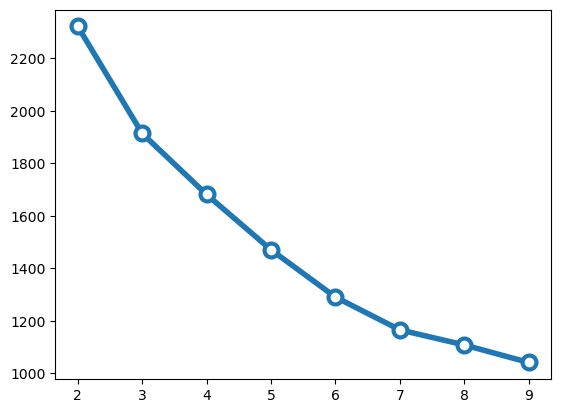

In [238]:
# Number of clusters to try out
n_clusters = list(range(2, 10))

# Run kmeans for each value of k
inertias = []
for k in n_clusters:
    
    # Initialize and run
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(claims_scaled)
    
    # Save the "inertia"
    inertias.append(kmeans.inertia_)
    
# Plot it!
plt.plot(n_clusters, inertias, marker='o', ms=10, mfc='white', lw=4, mew=3);

In [255]:
kmeans = KMeans(n_clusters=3, n_init=10)

In [256]:
claims_scaled = scaler.fit_transform(NJ_cluster_data[["mean_amountbuildingDamageAmount",
                                                      "mean_amountPaidOnBuildingClaim",
                                                      "mean_amountbuildingPropertyValue", 
                                                      "MedInc", 
                                                      "MedianAge", 
                                                      "pctWhite"]])
kmeans.fit(claims_scaled)

NJ_cluster_data['label'] = kmeans.labels_

NJ_cluster_data.groupby('label').size()

D:\Python\envs\musa-550-fall-2023\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


label
0    246
1     88
2    175
dtype: int64

In [257]:
claims_scaled = scaler.fit_transform(NJ_cluster_data[["mean_amountbuildingDamageAmount", 
                                                      "mean_amountbuildingPropertyValue", 
                                                      "MedInc", 
                                                      "MedianAge", 
                                                      "pctWhite"]])
kmeans.fit(claims_scaled)

NJ_cluster_data['label'] = kmeans.labels_

NJ_cluster_data.groupby('label', as_index=False).size()

D:\Python\envs\musa-550-fall-2023\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,label,size
0,0,240
1,1,182
2,2,87


In [258]:
NJ_cluster_data.groupby("label", as_index=False)[
    ["mean_amountbuildingDamageAmount", 
     "mean_amountbuildingPropertyValue",
     "mean_amountPaidOnBuildingClaim",
     "MedInc", 
     "MedianAge", 
     "pctWhite"]
].mean().sort_values(by="mean_amountbuildingDamageAmount")

,label,mean_amountbuildingDamageAmount,mean_amountbuildingPropertyValue,mean_amountPaidOnBuildingClaim,MedInc,MedianAge,pctWhite
0,0,13108.60,226001.50,12912.06,110796.88,43.65,79.34
1,1,14574.27,174849.14,14218.44,72198.75,37.64,52.46
2,2,47341.73,200199.75,48077.49,75579.21,50.67,86.78
